<a href="https://colab.research.google.com/github/MakhovaAnastasia/Paper_Fuzzy_LSTM/blob/main/%D0%A2%D0%B5%D1%81%D1%82%D1%8B_FuzzyLSTM1m1h1d.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

***LSTM на основе нечеткой логики.***

Тесты. Чтобы посмотреть результаты -- разверните скрытые ячейки.

## Необходимые  для запуска функции:

Импортируем нужные библиотеки

In [ ]:
import tensorflow as tf
from keras.layers import Dense, Activation, Dropout, Layer, RNN
from keras.layers import LSTM, Input
from keras.models import Sequential
from tensorflow.keras.layers import LSTMCell
import tensorflow.keras.backend as K
from keras.initializers import Constant
from keras.utils import get_custom_objects

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score,mean_absolute_percentage_error

import math
import numpy as np
import pandas as pd
import yfinance as yf
from datetime import date,timedelta
import time

from prettytable import PrettyTable
import matplotlib.pyplot as plt
plt.style.use('https://github.com/dhaitz/matplotlib-stylesheets/raw/master/pitayasmoothie-light.mplstyle')
%matplotlib inline

Собираем данные на разных тенорах

In [ ]:
def get_historical_close_data(name,step):
  if step=='1d':
    start = "1900-01-01"
    end = date.today()
    data = yf.Ticker(name)
    data=data.history(start=start, end=end,interval ='1d')
    data.reset_index(inplace=True)
    data = data.loc[:,('Date','Close')]
    data = data.sort_index(ascending = False)
    return data
  if step=='1h':
    start = date.today()-timedelta(days=729)
    end = date.today()
    data = yf.Ticker(name)
    data=data.history(start=start, end=end,interval ='1h')
    data.reset_index(inplace=True)
    data = data.loc[:,('Datetime','Close')]
    data = data.sort_index(ascending = False)
    return data
  if step=='1m':
    start = date.today()-timedelta(days=7)
    end = date.today()
    data = yf.Ticker(name)
    data=data.history(start=start, end=end,interval ='1m')
    data.reset_index(inplace=True)
    return data

Нормализация данных и денормализация

In [ ]:
def normalization(data):
    scaler = MinMaxScaler(feature_range = (0,1))
    data_norm = scaler.fit_transform(data)

    return data_norm

In [ ]:
def de_normalization(data, new_data):
    scaler = MinMaxScaler(feature_range = (0,1))
    scaler.fit_transform(data)
    unormalized = scaler.inverse_transform(new_data)

    return unormalized

Разбиваем данные на тренировочную и тестовую выборку и преобразуем их в нужный для LSTM формат

In [ ]:
def split_train_test(data):

    # split into train and test sets
    train_size = int(len(data) * 0.75)
    train, test = data[0:train_size,], data[train_size:len(data),]
    return train, test

def create_dataset(dataset, lookback):
    dataX, dataY = [], []
    for i in range(len(dataset)-lookback-1):
      a = dataset[i:(i+lookback), 0]
      dataX.append(a)
      dataY.append(dataset[i + lookback, 0])
    return np.array(dataX), np.array(dataY)

Фаззификация

In [ ]:
# 2. Фаззификация (гауссовая)
def compute_volatility(data, window):
    return pd.Series(data.flatten()).rolling(window).std().bfill().values

def fuzzify(data, window=10):
    sigma = compute_volatility(data, window)
    return np.exp(-((data.flatten() - data.flatten())**2) / (sigma**2 + 1e-8)).reshape(-1, 1)

     # === 4️⃣ Дефаззификация
def defuzzify(output_fuzzy, centers):
    return np.dot(output_fuzzy, centers) / np.sum(output_fuzzy, axis=1)

In [ ]:

class ParametricLSTMCell_sigmoid(LSTMCell):
    def build(self, input_shape):
        super().build(input_shape)
        # Добавляем параметры активации (α и β для сигмоиды)
        self.alpha = self.add_weight(
            name='alpha',
            shape=(1,),
            initializer=Constant(1.0),
            trainable=True
        )
        self.beta = self.add_weight(
            name='beta',
            shape=(1,),
            initializer=Constant(0.0),
            trainable=True
        )

    def param_sigmoid(self, x):
        return 1.0 / (1.0 + K.exp(-self.alpha * (x - self.beta)))

    def call(self, inputs, states, training=None):
        h_tm1 = states[0]  # предыдущий скрытый
        c_tm1 = states[1]  # предыдущий cell state

        z = K.dot(inputs, self.kernel)
        z += K.dot(h_tm1, self.recurrent_kernel)
        if self.use_bias:
            z = K.bias_add(z, self.bias)

        z0, z1, z2, z3 = tf.split(z, num_or_size_splits=4, axis=1)

        # Используем нашу сигмоиду
        i = self.param_sigmoid(z0)     # input gate
        f = self.param_sigmoid(z1)     # forget gate
        c = f * c_tm1 + i * K.tanh(z2) # cell state
        o = self.param_sigmoid(z3)     # output gate

        h = o * K.tanh(c)
        return h, [h, c]


In [ ]:
def create_dataset_multifeature_1(dataset, lookback):
    dataX, dataY = [], []
    for i in range(len(dataset)-lookback-1):
        a = dataset[i:(i+lookback), :]     # теперь берем все фичи
        dataX.append(a)
        dataY.append(dataset[i + lookback, 0])  # целевая переменная — всё так же первая (норм. цена)
    return np.array(dataX), np.array(dataY)

def create_dataset_multifeature(dataset, lookback):
    dataX, dataY = [], []
    for i in range(len(dataset) - lookback - 1):
        a = dataset[i:(i + lookback), :]
        dataX.append(a)
        dataY.append(dataset[i + lookback, :])  # теперь y — вектор из 2 значений
    return np.array(dataX), np.array(dataY)

-----
------
## LSTM с параметрической сигмоидой.

### parametricLSTM(step, unit, companies, lookback):

In [ ]:
def parametricLSTM(step, unit, companies, lookback):

  dataset = get_historical_close_data(companies,step)
  scaler=MinMaxScaler(feature_range=(0,1))
  dataset_norm=scaler.fit_transform(np.array(dataset['Close'].values).reshape(-1,1))
  train_dataset, test_dataset = split_train_test(dataset_norm)
  train_X, train_y = create_dataset(train_dataset, lookback)
  test_X, test_y = create_dataset(test_dataset,lookback)


  train_X =train_X.reshape(train_X.shape[0],train_X.shape[1] , 1)
  test_X = test_X.reshape(test_X.shape[0],test_X.shape[1] , 1)

  price_diff = np.abs(np.diff(np.array(dataset['Close'].values)))  # |S_t - S_{t-1}|

  mean_change = np.mean(price_diff)
  median_change = np.median(price_diff)
  std_change = np.std(price_diff)

  print(f"Среднее минутное изменение: {mean_change:.2f} $")
  print(f"Медианное изменение: {median_change:.2f} $")
  print(f"Стандартное отклонение изменений: {std_change:.2f} $")

  model = Sequential()
  model.add(Input(shape=(lookback, 1)))
  model.add(RNN(ParametricLSTMCell_sigmoid(unit)))
  model.add(Dense(1))
  model.compile(loss='mse', optimizer='adam')

  start_time = time.time()
  result=model.fit(train_X,train_y,validation_data=(test_X,test_y),epochs=100,batch_size=32,verbose=False)
  end_time = time.time()
  train_timing=(end_time-start_time)

  print(f"time = {train_timing}")

  train_predict=model.predict(train_X)
  start_time = time.time()
  test_predict=model.predict(test_X)
  end_time = time.time()
  test_timing=(end_time-start_time)
  print(f"time = {test_timing}")


  train_predict = scaler.inverse_transform(train_predict)
  test_predict = scaler.inverse_transform(test_predict)
  original_ytrain = scaler.inverse_transform(train_y.reshape(-1,1))
  original_ytest = scaler.inverse_transform(test_y.reshape(-1,1))

  trainPredictPlot = np.empty_like(dataset_norm)
  trainPredictPlot[:, ] = np.nan
  trainPredictPlot[lookback:len(train_predict)+lookback, ] = train_predict[:,0].reshape(-1,1)
  testPredictPlot = np.empty_like(dataset_norm)
  testPredictPlot[:,] = np.nan
  testPredictPlot[len(train_predict)+(lookback*2)+1:len(dataset['Close'])-1, ] = test_predict[:,0].reshape(-1,1)


  plt.plot(de_normalization(dataset['Close'].values.reshape(-1,1),dataset_norm),color = 'C2', label = 'data')
  plt.plot(trainPredictPlot,color = 'C0', label = 'train')
  plt.plot(testPredictPlot,color = 'C3', label = 'test')
  plt.legend()
  plt.show()

  plt.figure(figsize=(12, 6))
  plt.plot(de_normalization(dataset['Close'].values.reshape(-1,1),dataset_norm)[len(train_predict)+(lookback*2)+1:len(dataset['Close'])-1, ], label='Real Price')
  plt.plot(testPredictPlot[len(train_predict)+(lookback*2)+1:len(dataset['Close'])-1, ], label='Predicted Price')
  plt.legend()
  plt.show()

  rmse_train= math.sqrt(mean_squared_error(original_ytrain,train_predict))
  mae_train=mean_absolute_error(original_ytrain,train_predict)
  mape_train=mean_absolute_percentage_error(original_ytrain,train_predict)
  rmse_test=math.sqrt(mean_squared_error(original_ytest,test_predict))
  mae_test=mean_absolute_error(original_ytest,test_predict)
  mape_test=mean_absolute_percentage_error(original_ytest,test_predict)

  my_table = PrettyTable()
  my_table.field_names = [f"RESULTS", "TRAIN", "TEST"]
  my_table.add_row(["rmse", rmse_train, rmse_test])
  my_table.add_row(["mae", mae_train, mae_test])
  my_table.add_row(["mape",mape_train, mape_test])

  print(my_table)

  plt.plot(result.history['loss'],label = 'train loss')
  plt.plot(result.history['val_loss'],label = 'test loss')
  plt.legend()
  plt.show()

  return model


-----
### 1m

Среднее минутное изменение: 47.28 $
Медианное изменение: 29.70 $
Стандартное отклонение изменений: 55.08 $
time = 426.90186285972595
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
time = 0.34868836402893066


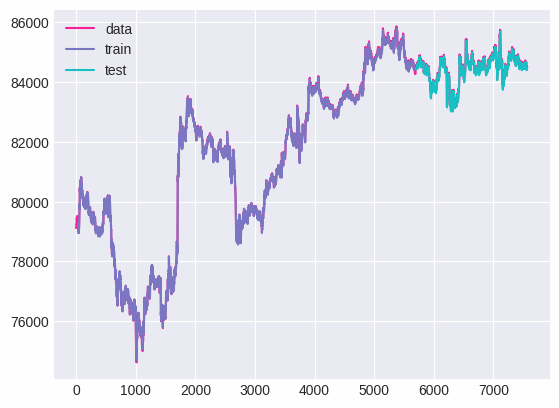

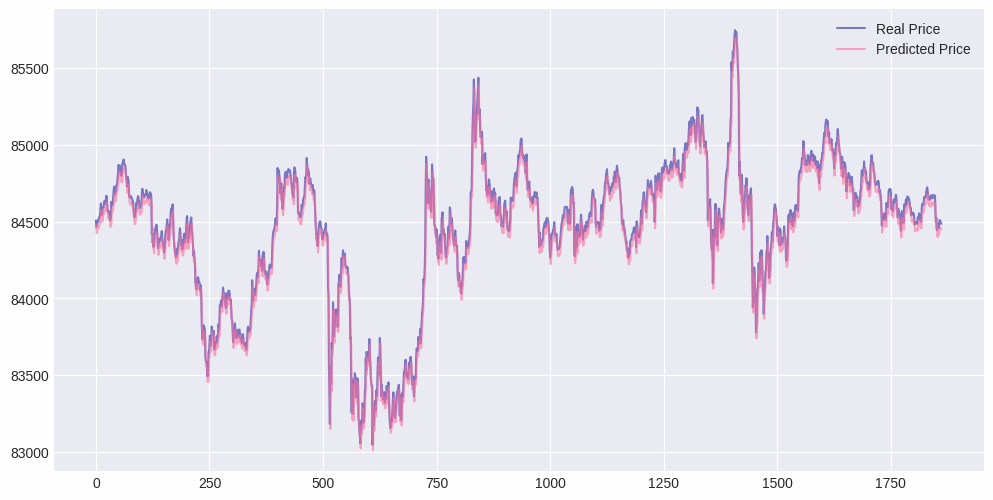

+---------+-----------------------+----------------------+
| RESULTS |         TRAIN         |         TEST         |
+---------+-----------------------+----------------------+
|   rmse  |   80.42207236168412   |  76.66754676932338   |
|   mae   |   57.32430177337938   |   59.0788340829753   |
|   mape  | 0.0007096241981736016 | 0.000699679118017367 |
+---------+-----------------------+----------------------+


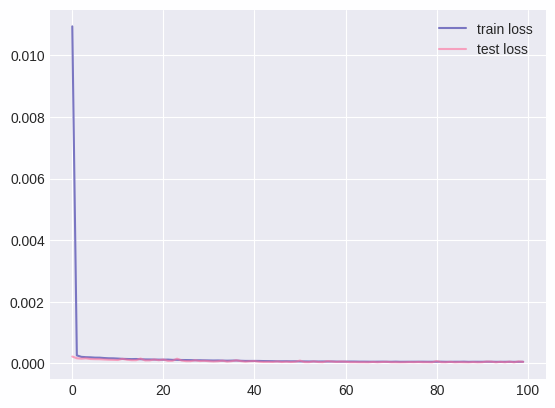

<Sequential name=sequential_38, built=True>

In [ ]:
step= '1m'
unit = 16
companies = 'BTC-USD'
lookback=30

parametricLSTM(step, unit, companies, lookback)

---
### 1h

Среднее минутное изменение: 201.71 $
Медианное изменение: 106.50 $
Стандартное отклонение изменений: 286.00 $
time = 967.3934898376465
408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
136/136 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
time = 0.7078831195831299


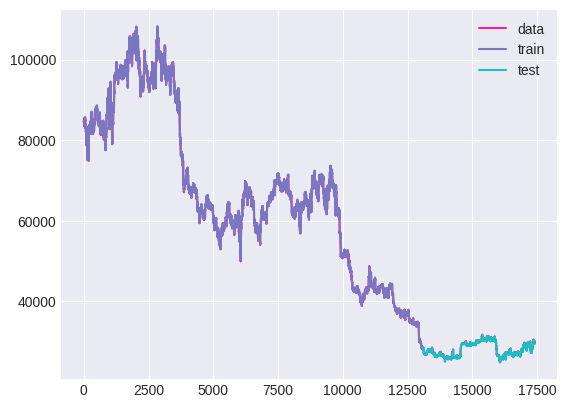

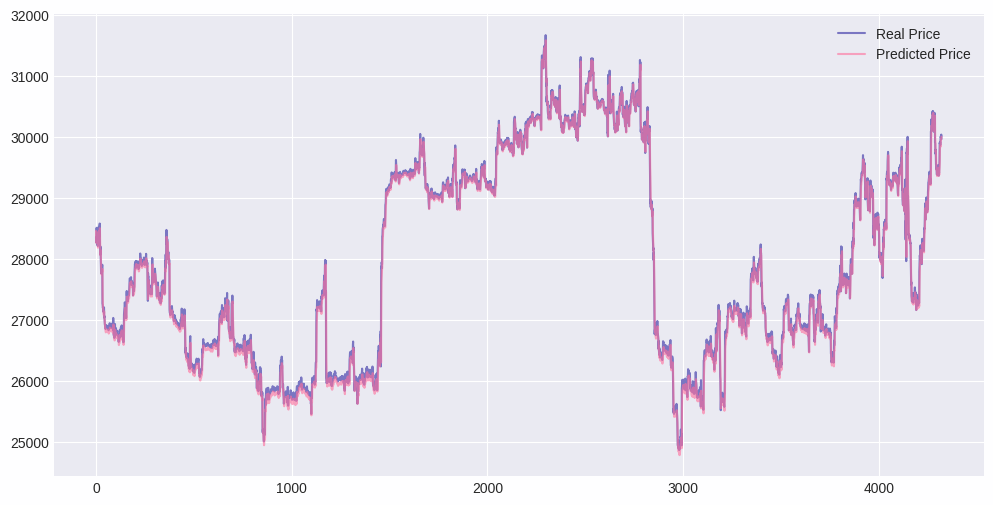

+---------+----------------------+-----------------------+
| RESULTS |        TRAIN         |          TEST         |
+---------+----------------------+-----------------------+
|   rmse  |  400.96811358567544  |   127.4488486435829   |
|   mae   |  251.10943482166817  |   85.79485680096018   |
|   mape  | 0.003685083479839157 | 0.0030936478721562384 |
+---------+----------------------+-----------------------+


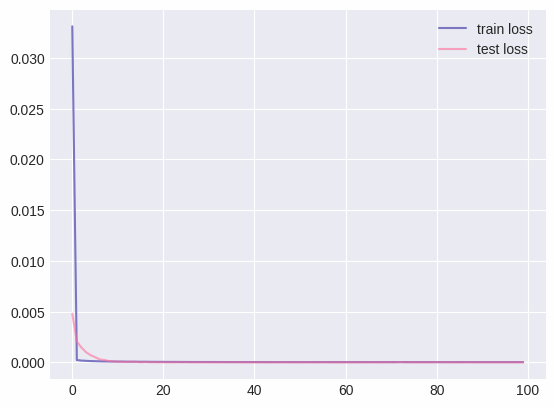

<Sequential name=sequential_39, built=True>

In [ ]:
step= '1h'
unit = 16
companies = 'BTC-USD'
lookback=30

parametricLSTM(step, unit, companies, lookback)

----
### 1d


Среднее минутное изменение: 497.81 $
Медианное изменение: 133.71 $
Стандартное отклонение изменений: 889.85 $
time = 54.67308855056763
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
time = 0.1369032859802246


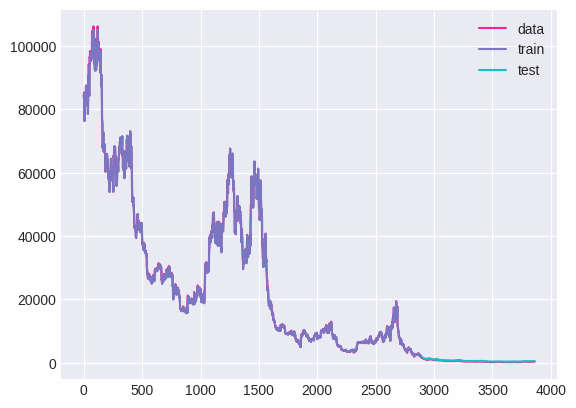

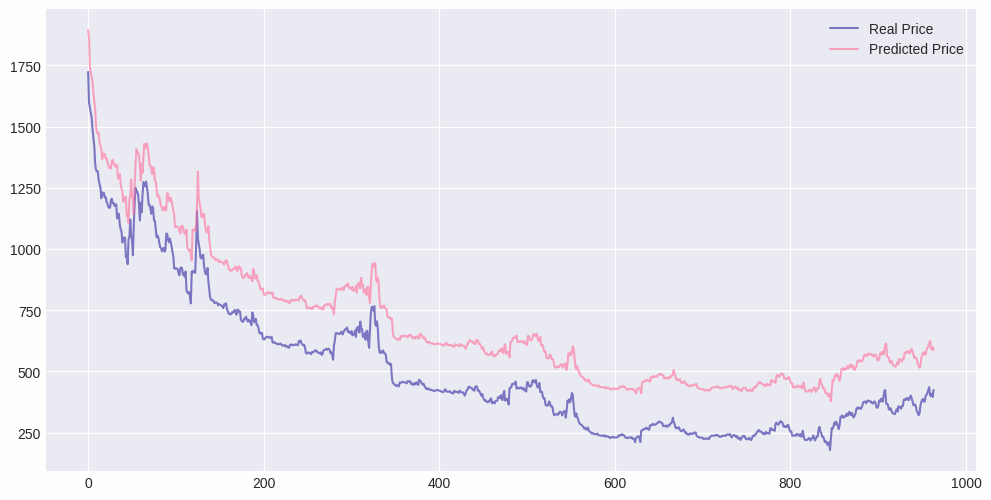

+---------+----------------------+--------------------+
| RESULTS |        TRAIN         |        TEST        |
+---------+----------------------+--------------------+
|   rmse  |  1185.8253166620116  | 189.34769359522085 |
|   mae   |  680.3525336652634   | 188.23312400089753 |
|   mape  | 0.026593458864470988 | 0.495225183979027  |
+---------+----------------------+--------------------+


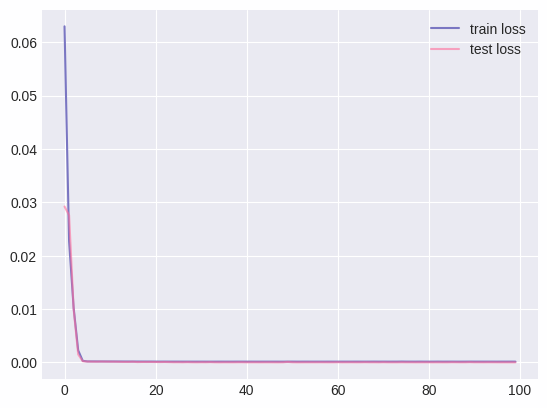

<Sequential name=sequential_40, built=True>

In [ ]:
step= '1d'
unit = 16
companies = 'BTC-USD'
lookback=1

parametricLSTM(step, unit, companies, lookback)

------
-----

----------
---------

## **Fuzzy LSTM**

### FuzzyLSTM(step, unit, companies, lookback, window):

In [ ]:
def FuzzyLSTM(step, unit, companies, lookback, window):
  #  Создание датасета с признаками
  dataset = get_historical_close_data(companies,step)
  scaler=MinMaxScaler(feature_range=(0,1))
  dataset_norm=scaler.fit_transform(np.array(dataset['Close'].values).reshape(-1,1))

  price_diff = np.abs(np.diff(np.array(dataset['Close'].values)))  # |S_t - S_{t-1}|

  mean_change = np.mean(price_diff)
  median_change = np.median(price_diff)
  std_change = np.std(price_diff)

  print(f"Среднее минутное изменение: {mean_change:.2f} $")
  print(f"Медианное изменение: {median_change:.2f} $")
  print(f"Стандартное отклонение изменений: {std_change:.2f} $")


  # === Фаззи-признак ===
  fuzzy_feature = fuzzify(dataset_norm, window)

  # Добавим фаззи-признак в нормализованный датасет
  dataset_fuzzy = np.hstack((dataset_norm, fuzzy_feature))  # shape = (n_samples, 2)

  train_dataset_fuzzy, test_dataset_fuzzy = split_train_test(dataset_fuzzy)

  train_X, train_y = create_dataset_multifeature(train_dataset_fuzzy, lookback)
  test_X, test_y = create_dataset_multifeature(test_dataset_fuzzy, lookback)


  train_X =train_X.reshape(train_X.shape[0],train_X.shape[1] , 2)
  test_X = test_X.reshape(test_X.shape[0],test_X.shape[1] , 2)

  model = Sequential()
  model.add(Input(shape=(lookback, 2)))
  model.add(RNN(ParametricLSTMCell_sigmoid(unit)))
  model.add(Dense(2))
  model.compile(loss='mse', optimizer='adam')

  # === Обучение ===
  start_time = time.time()
  history = model.fit(train_X, train_y, epochs=100, batch_size=32, validation_data=(test_X, test_y), verbose=False)
  train_time = time.time() - start_time
  print(f"time = {train_time}")

  # === Предсказания ===
  train_predict = model.predict(train_X)
  test_predict = model.predict(test_X)

  #Де-нормализация предсказаний и реальных значений
  train_pred_denorm = scaler.inverse_transform(train_predict.T.reshape(-1, 1))
  test_pred_denorm = scaler.inverse_transform(test_predict.T.reshape(-1, 1))
  y_train_denorm = scaler.inverse_transform(train_y.T.reshape(-1, 1))
  y_test_denorm = scaler.inverse_transform(test_y.T.reshape(-1, 1))


  # === Метрики ===
  rmse_train= math.sqrt(mean_squared_error(y_train_denorm, train_pred_denorm))
  mae_train=mean_absolute_error(y_train_denorm, train_pred_denorm)
  mape_train=mean_absolute_percentage_error(y_train_denorm, train_pred_denorm)
  rmse_test=math.sqrt(mean_squared_error(y_test_denorm, test_pred_denorm))
  mae_test=mean_absolute_error(y_test_denorm, test_pred_denorm)
  mape_test=mean_absolute_percentage_error(y_test_denorm, test_pred_denorm)

  my_table = PrettyTable()
  my_table.field_names = [f"RESULTS", "TRAIN", "TEST"]
  my_table.add_row(["rmse", rmse_train, rmse_test])
  my_table.add_row(["mae", mae_train, mae_test])
  my_table.add_row(["mape",mape_train, mape_test])

  print(my_table)

  # === Визуализация ===
  l = np.shape(y_test_denorm)[0]
  plt.figure(figsize=(12, 6))
  plt.plot(y_test_denorm[:int(l/2),0], label='Real Price')
  plt.plot(test_pred_denorm[:int(l/2),0], label='Predicted Price')
  plt.title("Предсказание цены с фаззи-признаками")
  plt.legend()
  plt.show()

  plt.figure(figsize=(8, 4))
  plt.plot(history.history['loss'], label='Train Loss')
  plt.plot(history.history['val_loss'], label='Val Loss')
  plt.title("График потерь")
  plt.legend()
  plt.show()

  return model


### 1m

Среднее минутное изменение: 47.28 $
Медианное изменение: 29.70 $
Стандартное отклонение изменений: 55.08 $
time = 427.58153653144836
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
+---------+-----------------------+------------------------+
| RESULTS |         TRAIN         |          TEST          |
+---------+-----------------------+------------------------+
|   rmse  |   54.39665753690513   |   46.326827672443684   |
|   mae   |   30.719595454746724  |   27.54970294038668    |
|   mape  | 0.0003777144351229165 | 0.00032518637679777954 |
+---------+-----------------------+------------------------+


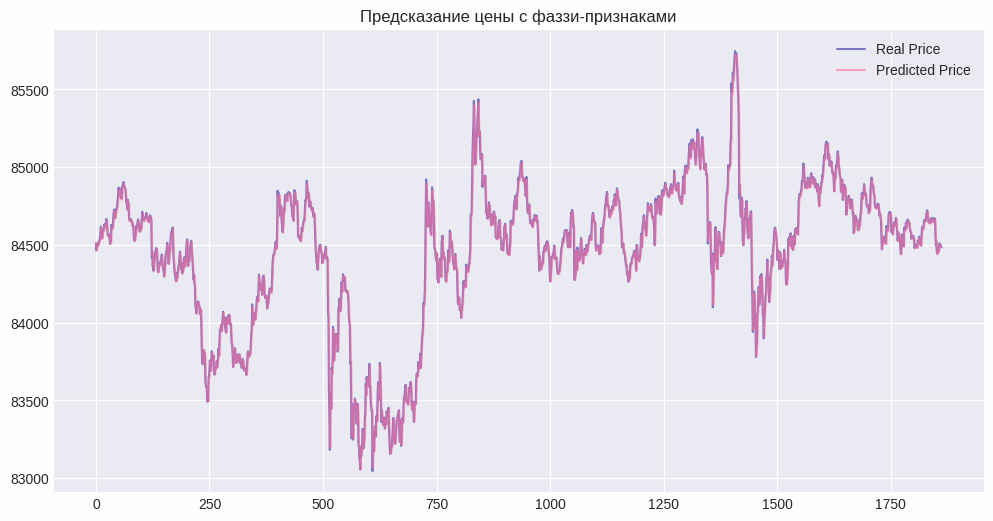

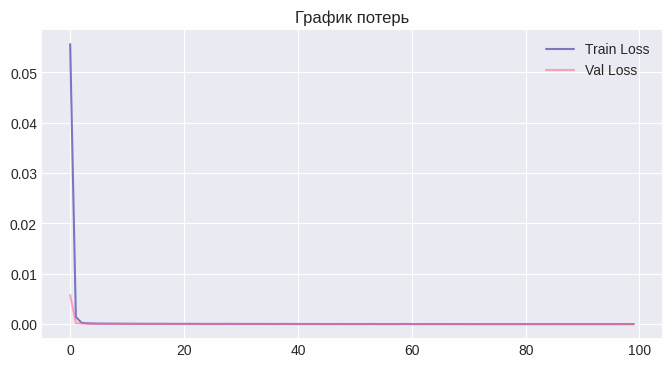

<Sequential name=sequential_24, built=True>

In [ ]:
step= '1m'
unit = 16
companies = 'BTC-USD'
lookback=30
window = 10

FuzzyLSTM(step, unit, companies, lookback, window)

### 1h

Среднее минутное изменение: 201.71 $
Медианное изменение: 106.50 $
Стандартное отклонение изменений: 286.00 $
time = 911.8582413196564
408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
136/136 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
+---------+-----------------------+-----------------------+
| RESULTS |         TRAIN         |          TEST         |
+---------+-----------------------+-----------------------+
|   rmse  |   413.7120509895753   |   89.64278687904766   |
|   mae   |   277.0414441220633   |   51.97202900856085   |
|   mape  | 0.0037166913600452066 | 0.0015919137143703167 |
+---------+-----------------------+-----------------------+


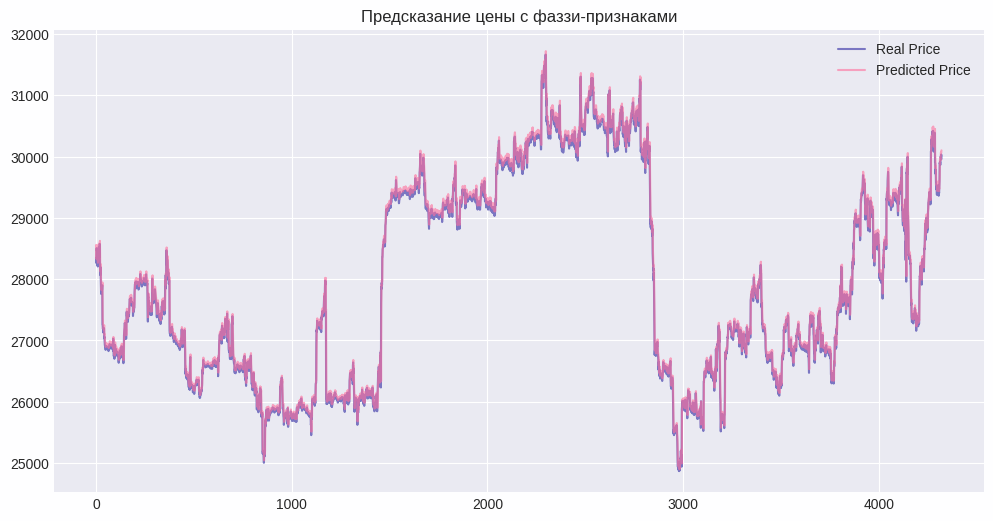

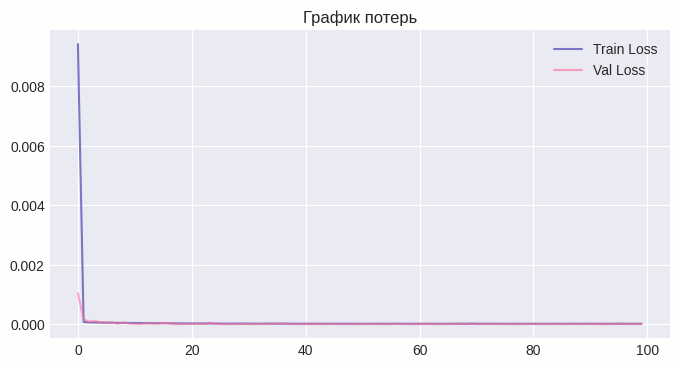

<Sequential name=sequential_25, built=True>

In [ ]:
step= '1h'
unit = 16
companies = 'BTC-USD'
lookback=30
window = 10

FuzzyLSTM(step, unit, companies, lookback, window)

### 1d


Среднее минутное изменение: 497.81 $
Медианное изменение: 133.71 $
Стандартное отклонение изменений: 889.85 $
time = 56.31920504570007
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
+---------+----------------------+---------------------+
| RESULTS |        TRAIN         |         TEST        |
+---------+----------------------+---------------------+
|   rmse  |  871.0311397578841   |  271.15694083225014 |
|   mae   |  392.8022182431657   |  234.2517895995334  |
|   mape  | 0.015760664779916778 | 0.48738115141171473 |
+---------+----------------------+---------------------+


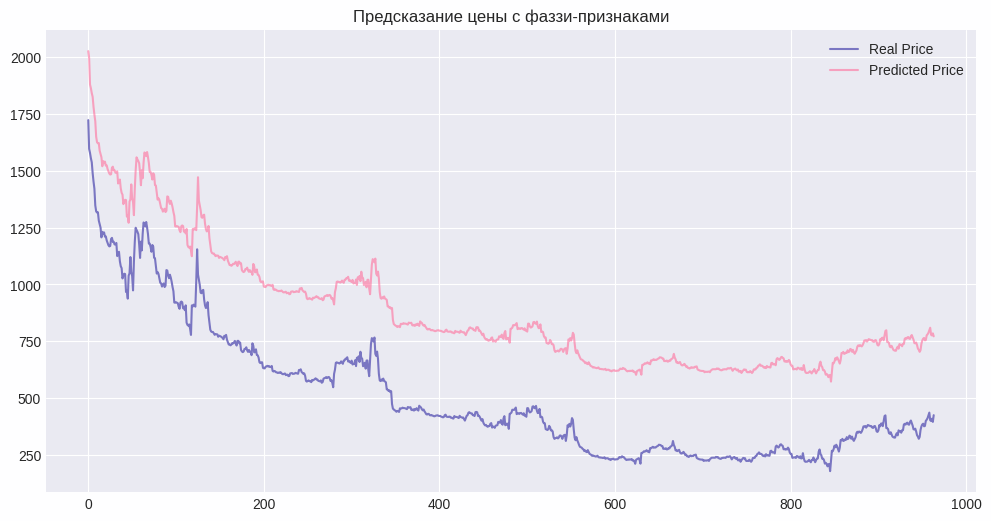

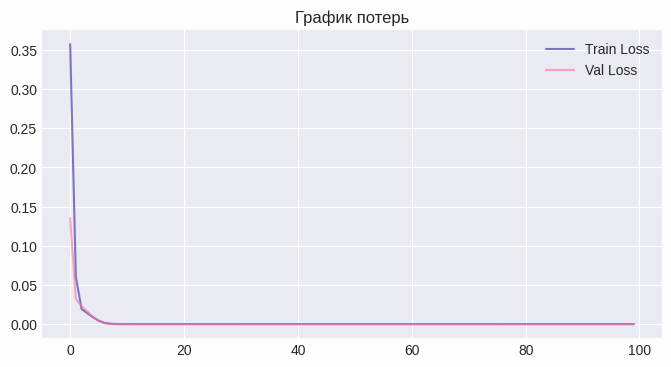

<Sequential name=sequential_26, built=True>

In [ ]:
step= '1d'
unit = 16
companies = 'BTC-USD'
lookback=1
window = 10

FuzzyLSTM(step, unit, companies, lookback, window)

-----
-----

-------------
-----------
##Нечеткая предобработка

### fuzzy_data(step, unit, companies, lookback, window):

In [ ]:
def fuzzy_data(step, unit, companies, lookback, window):

  dataset = get_historical_close_data(companies,step)
  scaler=MinMaxScaler(feature_range=(0,1))
  dataset_norm=scaler.fit_transform(np.array(dataset['Close'].values).reshape(-1,1))

  price_diff = np.abs(np.diff(np.array(dataset['Close'].values)))  # |S_t - S_{t-1}|

  mean_change = np.mean(price_diff)
  median_change = np.median(price_diff)
  std_change = np.std(price_diff)

  print(f"Среднее минутное изменение: {mean_change:.2f} $")
  print(f"Медианное изменение: {median_change:.2f} $")
  print(f"Стандартное отклонение изменений: {std_change:.2f} $")

  # === Фаззи-признак ===
  fuzzy_feature = fuzzify(dataset_norm, window)

  # Добавим фаззи-признак в нормализованный датасет
  dataset_fuzzy = np.hstack((dataset_norm, fuzzy_feature))  # shape = (n_samples, 2)

  train_dataset_fuzzy, test_dataset_fuzzy = split_train_test(dataset_fuzzy)

  train_X, train_y = create_dataset_multifeature_1(train_dataset_fuzzy, lookback)
  test_X, test_y = create_dataset_multifeature_1(test_dataset_fuzzy, lookback)



  train_X =train_X.reshape(train_X.shape[0],train_X.shape[1] , 2)
  test_X = test_X.reshape(test_X.shape[0],test_X.shape[1] , 2)


  model=Sequential()
  model.add(Input(shape=(lookback,2)))
  model.add(LSTM(unit))
  model.add(Dense(1))
  model.compile(loss='mean_squared_error',optimizer='adam')

  start_time = time.time()
  result=model.fit(train_X,train_y,validation_data=(test_X,test_y),epochs=100,batch_size=32,verbose=False)
  end_time = time.time()
  train_timing=(end_time-start_time)
  print(f"time = {train_timing}")

  train_predict=model.predict(train_X)
  start_time = time.time()
  test_predict=model.predict(test_X)
  end_time = time.time()
  test_timing=(end_time-start_time)
  print(f"time = {test_timing}")

  train_predict = scaler.inverse_transform(train_predict)
  test_predict = scaler.inverse_transform(test_predict)
  original_ytrain = scaler.inverse_transform(train_y.reshape(-1,1))
  original_ytest = scaler.inverse_transform(test_y.reshape(-1,1))

  trainPredictPlot = np.empty_like(dataset_norm)
  trainPredictPlot[:, ] = np.nan
  trainPredictPlot[lookback:len(train_predict)+lookback, ] = train_predict[:,0].reshape(-1,1)
  testPredictPlot = np.empty_like(dataset_norm)
  testPredictPlot[:,] = np.nan
  testPredictPlot[len(train_predict)+(lookback*2)+1:len(dataset['Close'])-1, ] = test_predict[:,0].reshape(-1,1)

  plt.plot(de_normalization(dataset['Close'].values.reshape(-1,1),dataset_norm),color = 'C2', label = 'data')
  plt.plot(trainPredictPlot,color = 'C0', label = 'train')
  plt.plot(testPredictPlot,color = 'C3', label = 'test')
  plt.legend()
  plt.show()

  rmse_train= math.sqrt(mean_squared_error(original_ytrain,train_predict))
  mae_train=mean_absolute_error(original_ytrain,train_predict)
  mape_train=mean_absolute_percentage_error(original_ytrain,train_predict)
  rmse_test=math.sqrt(mean_squared_error(original_ytest,test_predict))
  mae_test=mean_absolute_error(original_ytest,test_predict)
  mape_test=mean_absolute_percentage_error(original_ytest,test_predict)

  my_table = PrettyTable()
  my_table.field_names = [f"RESULTS", "TRAIN", "TEST"]
  my_table.add_row(["rmse", rmse_train, rmse_test])
  my_table.add_row(["mae", mae_train, mae_test])
  my_table.add_row(["mape",mape_train, mape_test])

  print(my_table)

  plt.plot(result.history['loss'],label = 'train loss')
  plt.plot(result.history['val_loss'],label = 'test loss')
  plt.legend()
  plt.show()

  return model


-----
### 1m

Среднее минутное изменение: 47.28 $
Медианное изменение: 29.70 $
Стандартное отклонение изменений: 55.08 $
time = 295.467910528183
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
time = 0.30291032791137695


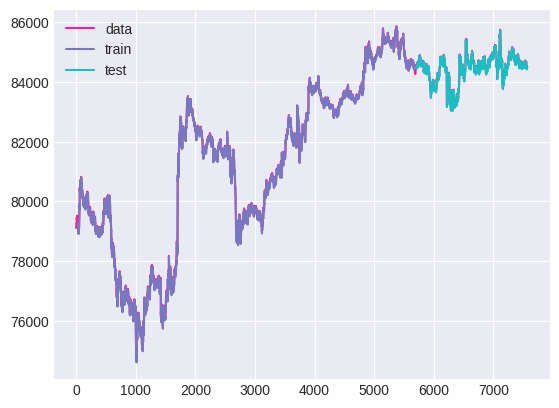

+---------+-----------------------+-----------------------+
| RESULTS |         TRAIN         |          TEST         |
+---------+-----------------------+-----------------------+
|   rmse  |   80.86895883932834   |   66.10001659431504   |
|   mae   |   55.94737424725469   |   45.54024150778733   |
|   mape  | 0.0006960829396056682 | 0.0005396104451589685 |
+---------+-----------------------+-----------------------+


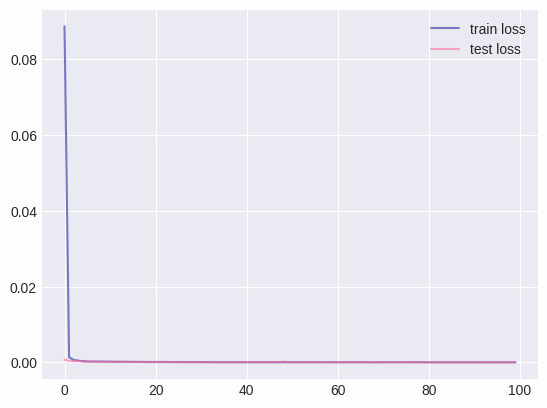

<Sequential name=sequential_27, built=True>

In [ ]:
step= '1m'
unit = 16
companies = 'BTC-USD'
lookback=30
window = 10

fuzzy_data(step, unit, companies, lookback, window)

------
### 1h

Среднее минутное изменение: 201.71 $
Медианное изменение: 106.50 $
Стандартное отклонение изменений: 286.00 $
time = 627.2068049907684
408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
136/136 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
time = 0.6161158084869385


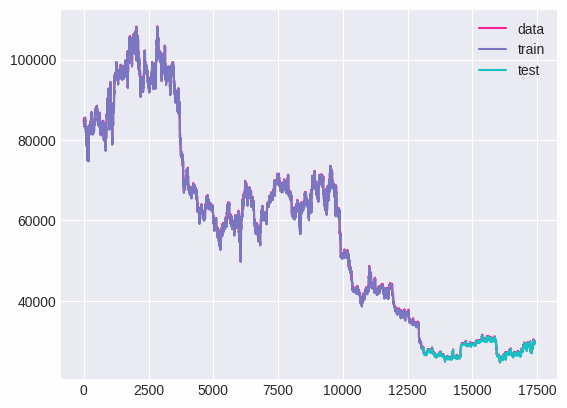

+---------+----------------------+----------------------+
| RESULTS |        TRAIN         |         TEST         |
+---------+----------------------+----------------------+
|   rmse  |  429.21303139515607  |  184.91710674666194  |
|   mae   |  296.12142224442556  |  157.78943306050436  |
|   mape  | 0.004579182588625953 | 0.005633255728249598 |
+---------+----------------------+----------------------+


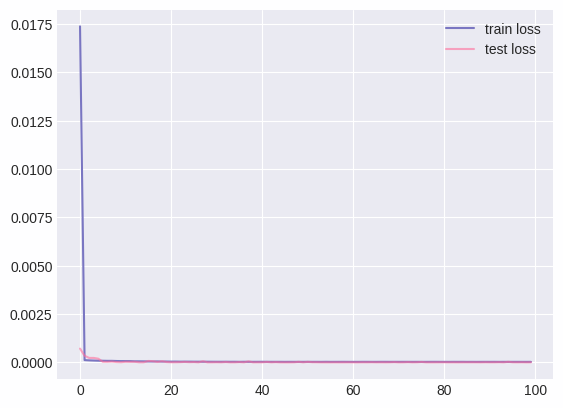

<Sequential name=sequential_28, built=True>

In [ ]:
step= '1h'
unit = 16
companies = 'BTC-USD'
lookback=30
window = 10

fuzzy_data(step, unit, companies, lookback, window)

---
### 1d

Среднее минутное изменение: 497.81 $
Медианное изменение: 133.71 $
Стандартное отклонение изменений: 889.85 $
time = 52.72741508483887
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
time = 0.20960068702697754


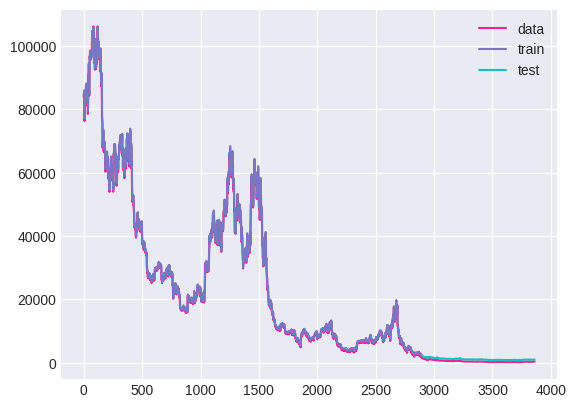

+---------+---------------------+-------------------+
| RESULTS |        TRAIN        |        TEST       |
+---------+---------------------+-------------------+
|   rmse  |  1296.3405306089287 | 669.2094170022671 |
|   mae   |  875.7055091027769  | 668.9107913891804 |
|   mape  | 0.05426279603926747 | 1.731635460373495 |
+---------+---------------------+-------------------+


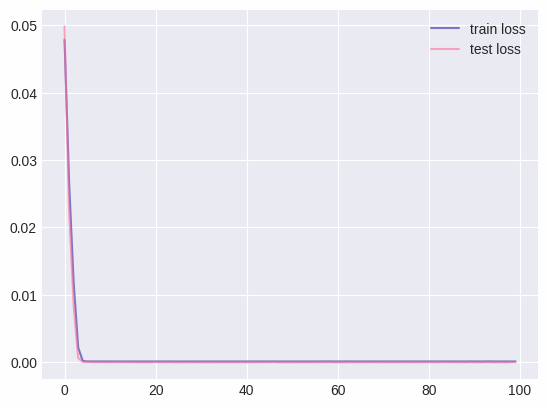

<Sequential name=sequential_29, built=True>

In [ ]:
step= '1d'
unit = 16
companies = 'BTC-USD'
lookback=1
window = 10

fuzzy_data(step, unit, companies, lookback, window)

---------
--------
## LSTM

###  vanilla_LSTM(step, unit, companies, lookback):

In [ ]:
def vanilla_LSTM(step, unit, companies, lookback):

  #Подготавливаем данные: скачиваем, нормализуем, формируем выборки
  dataset = get_historical_close_data(companies,step)
  scaler=MinMaxScaler(feature_range=(0,1))
  dataset_norm=scaler.fit_transform(np.array(dataset['Close'].values).reshape(-1,1))
  train_dataset, test_dataset = split_train_test(dataset_norm)
  train_X, train_y = create_dataset(train_dataset, lookback)
  test_X, test_y = create_dataset(test_dataset,lookback)


  train_X =train_X.reshape(train_X.shape[0],train_X.shape[1] , 1)
  test_X = test_X.reshape(test_X.shape[0],test_X.shape[1] , 1)


  price_diff = np.abs(np.diff(np.array(dataset['Close'].values)))  # |S_t - S_{t-1}|

  mean_change = np.mean(price_diff)
  median_change = np.median(price_diff)
  std_change = np.std(price_diff)

  print(f"Среднее минутное изменение: {mean_change:.2f} $")
  print(f"Медианное изменение: {median_change:.2f} $")
  print(f"Стандартное отклонение изменений: {std_change:.2f} $")


  #Запускаем обучение LSTM с функцией потерь MSE и алгоритмом оптимизации ADAM
  model=Sequential()
  model = Sequential()
  model.add(Input(shape=(lookback,1)))  # Вот так правильно
  model.add(LSTM(unit))
  model.add(Dense(1))
  model.compile(loss='mean_squared_error',optimizer='adam')
  start_time = time.time()
  result=model.fit(train_X,train_y,validation_data=(test_X,test_y),epochs=100,batch_size=32,verbose=False)
  end_time = time.time()
  train_timing=(end_time-start_time)

  print(f"time = {train_timing}")

  #Делаем прогноз на тренировочной и тестовой выборке
  train_predict=model.predict(train_X)
  start_time = time.time()
  test_predict=model.predict(test_X)
  end_time = time.time()
  test_timing=(end_time-start_time)

  print(f"time = {test_timing}")

  #Возвращаем данные в исходные единицы измерения
  train_predict = scaler.inverse_transform(train_predict)
  test_predict = scaler.inverse_transform(test_predict)
  original_ytrain = scaler.inverse_transform(train_y.reshape(-1,1))
  original_ytest = scaler.inverse_transform(test_y.reshape(-1,1))

  trainPredictPlot = np.empty_like(dataset_norm)
  trainPredictPlot[:, ] = np.nan
  trainPredictPlot[lookback:len(train_predict)+lookback, ] = train_predict[:,0].reshape(-1,1)
  testPredictPlot = np.empty_like(dataset_norm)
  testPredictPlot[:,] = np.nan
  testPredictPlot[len(train_predict)+(lookback*2)+1:len(dataset['Close'])-1, ] = test_predict[:,0].reshape(-1,1)


  #График с оригинальными данными и прогнозами:
  plt.plot(de_normalization(dataset['Close'].values.reshape(-1,1),dataset_norm),color = 'C2', label = 'data')
  plt.plot(trainPredictPlot,color = 'C0', label = 'train')
  plt.plot(testPredictPlot,color = 'C3', label = 'test')
  plt.legend()
  plt.show()

  plt.figure(figsize=(12, 6))
  plt.plot(de_normalization(dataset['Close'].values.reshape(-1,1),dataset_norm)[len(train_predict)+(lookback*2)+1:len(dataset['Close'])-1, ], label='Real Price')
  plt.plot(testPredictPlot[len(train_predict)+(lookback*2)+1:len(dataset['Close'])-1, ], label='Predicted Price')
  plt.title("Предсказание цены")
  plt.legend()
  plt.show()

  #метрики
  rmse_train= math.sqrt(mean_squared_error(original_ytrain,train_predict))
  mae_train=mean_absolute_error(original_ytrain,train_predict)
  mape_train=mean_absolute_percentage_error(original_ytrain,train_predict)
  rmse_test=math.sqrt(mean_squared_error(original_ytest,test_predict))
  mae_test=mean_absolute_error(original_ytest,test_predict)
  mape_test=mean_absolute_percentage_error(original_ytest,test_predict)

  my_table = PrettyTable()
  my_table.field_names = [f"RESULTS", "TRAIN", "TEST"]
  my_table.add_row(["rmse", rmse_train, rmse_test])
  my_table.add_row(["mae", mae_train, mae_test])
  my_table.add_row(["mape",mape_train, mape_test])

  print(my_table)

  #График функций потерь:
  plt.plot(result.history['loss'],label = 'train loss')
  plt.plot(result.history['val_loss'],label = 'test loss')
  plt.legend()
  plt.show()

  return

------
### 1m

In [ ]:
step= '1m'
unit = 16
companies = 'BTC-USD'
lookback=30

Среднее минутное изменение: 47.28 $
Медианное изменение: 29.70 $
Стандартное отклонение изменений: 55.08 $
time = 265.2948522567749
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
time = 0.29709792137145996


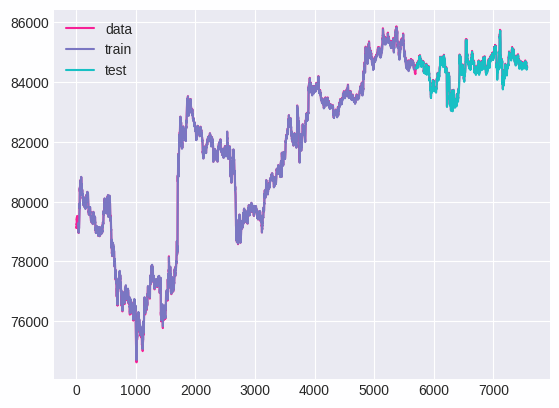

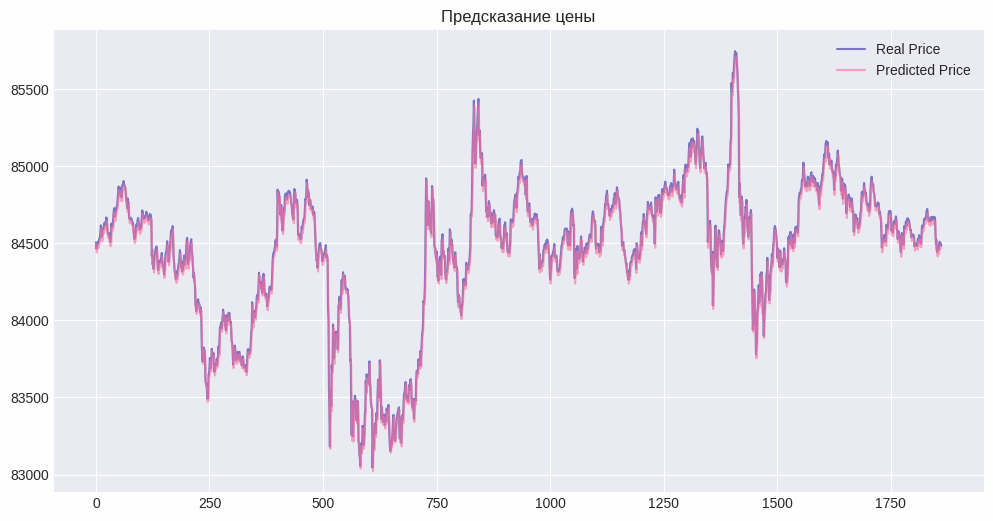

+---------+-----------------------+----------------------+
| RESULTS |         TRAIN         |         TEST         |
+---------+-----------------------+----------------------+
|   rmse  |   77.94271092851893   |  68.09909887880853   |
|   mae   |   52.88072584573149   |  48.47705759935553   |
|   mape  | 0.0006572640690883183 | 0.000574302501216107 |
+---------+-----------------------+----------------------+


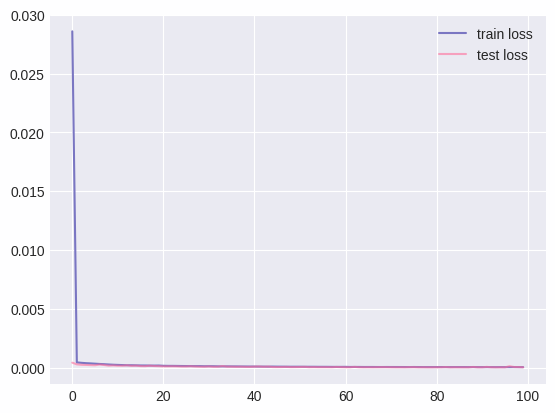

In [ ]:
vanilla_LSTM(step, unit, companies, lookback)

---------
### 1h

Среднее минутное изменение: 201.71 $
Медианное изменение: 106.50 $
Стандартное отклонение изменений: 286.00 $
time = 601.9840004444122
408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
time = 0.6803369522094727


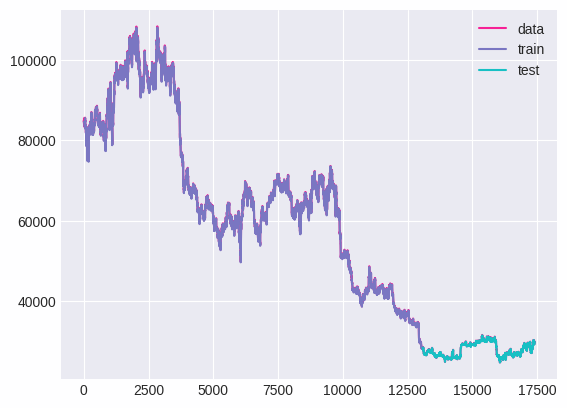

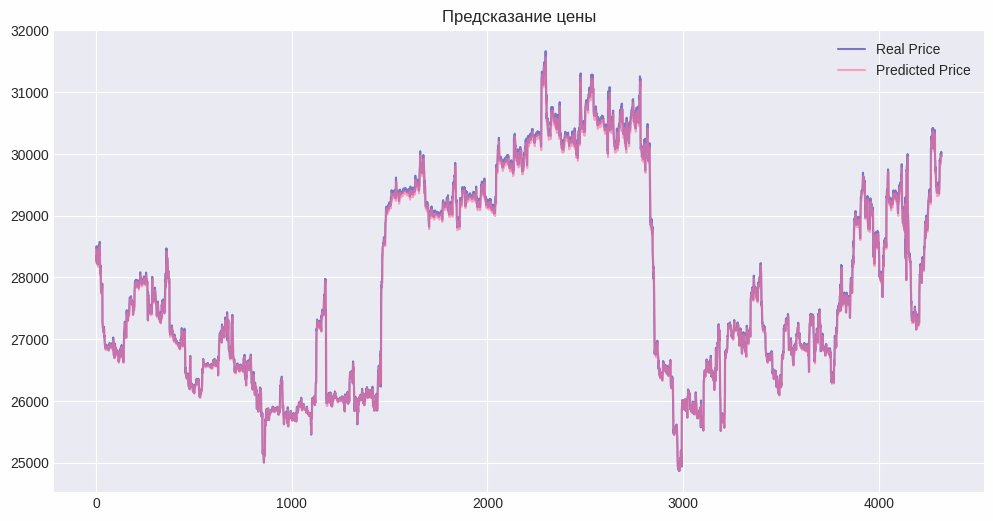

+---------+----------------------+----------------------+
| RESULTS |        TRAIN         |         TEST         |
+---------+----------------------+----------------------+
|   rmse  |  426.6843498169657   |  116.97272774372375  |
|   mae   |  283.32105854667276  |  72.45958405035283   |
|   mape  | 0.004194938049960077 | 0.002576466428482674 |
+---------+----------------------+----------------------+


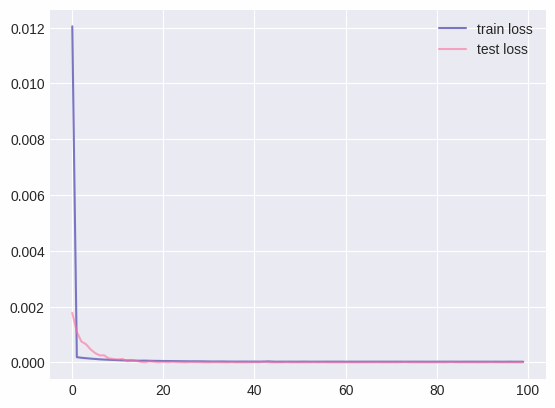

In [ ]:
step= '1h'
unit = 16
companies = 'BTC-USD'
lookback=30
vanilla_LSTM(step, unit, companies, lookback)

---------
### 1d

Среднее минутное изменение: 497.81 $
Медианное изменение: 133.71 $
Стандартное отклонение изменений: 889.85 $
time = 53.60113334655762
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
time = 0.13599324226379395


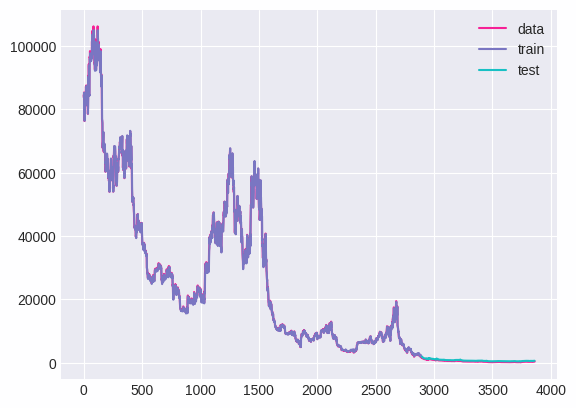

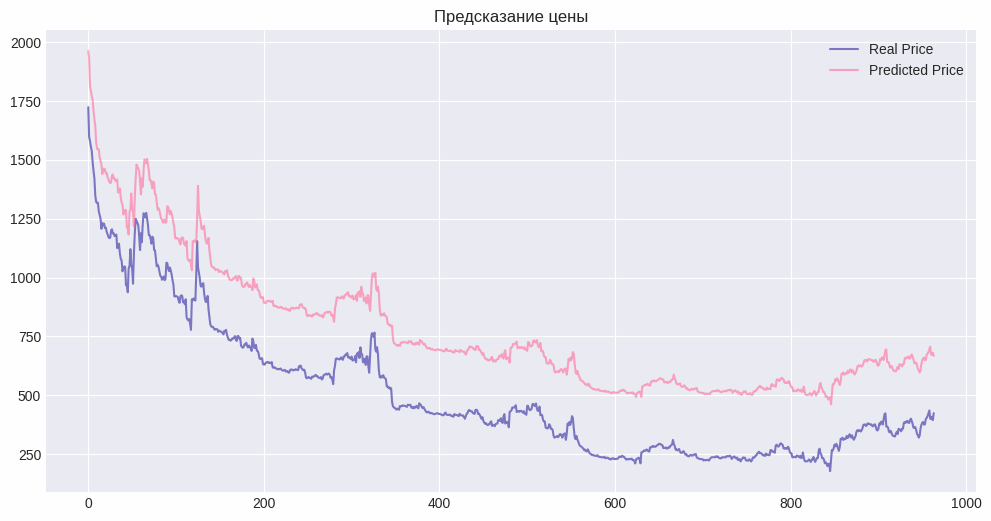

+---------+----------------------+--------------------+
| RESULTS |        TRAIN         |        TEST        |
+---------+----------------------+--------------------+
|   rmse  |  1189.101664069453   |  269.436159440157  |
|   mae   |  686.9120118874137   | 268.53926573947257 |
|   mape  | 0.027897929842805563 | 0.7052659315151507 |
+---------+----------------------+--------------------+


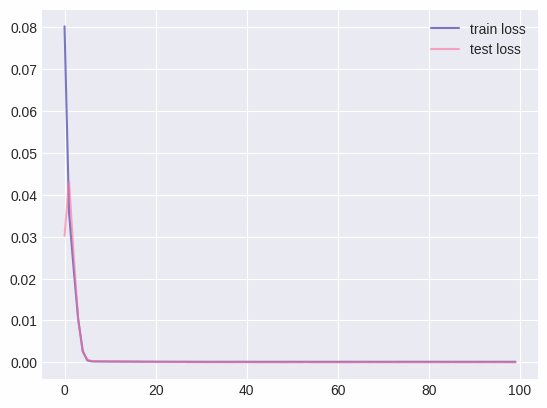

In [ ]:
step= '1d'
unit = 16
companies = 'BTC-USD'
lookback=1
vanilla_LSTM(step, unit, companies, lookback)

------
------
##Delta LSTM

Это попытка избавления от сдвига: предсказание самого скачка. *Пока не работает*


In [ ]:
def delta_LSTM(step, unit, companies, lookback):
    # Подготовка данных
    dataset = get_historical_close_data(companies, step)
    close_prices = np.array(dataset['Close'].values)
    deltas = np.diff(close_prices)

    # Нормализация дельт
    scaler = MinMaxScaler(feature_range=(-1, 1))
    deltas_norm = scaler.fit_transform(deltas.reshape(-1, 1))

    train_dataset, test_dataset = split_train_test(deltas_norm)
    train_X, train_y = create_dataset(train_dataset, lookback)
    test_X, test_y = create_dataset(test_dataset, lookback)

    train_X = train_X.reshape(train_X.shape[0], train_X.shape[1], 1)
    test_X = test_X.reshape(test_X.shape[0], test_X.shape[1], 1)

    # Модель
    model = Sequential()
    model.add(Input(shape=(lookback, 1)))
    model.add(LSTM(unit))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')

    # Обучение
    start_time = time.time()
    result = model.fit(train_X, train_y, validation_data=(test_X, test_y), epochs=10, batch_size=32, verbose=False)
    print(f"Train time = {time.time() - start_time:.2f} sec")

    # Предсказания дельт
    train_predict_delta = model.predict(train_X)
    test_predict_delta = model.predict(test_X)

    # Де-нормализация дельт
    train_predict_delta = scaler.inverse_transform(train_predict_delta)
    test_predict_delta = scaler.inverse_transform(test_predict_delta)
    original_ytrain = scaler.inverse_transform(train_y.reshape(-1, 1))
    original_ytest = scaler.inverse_transform(test_y.reshape(-1, 1))

    # Восстановление цен
    full_pred_deltas = np.concatenate([train_predict_delta, test_predict_delta])
    restored_price = np.cumsum(np.insert(full_pred_deltas, 0, close_prices[0]))
    actual_price = close_prices[:len(restored_price)]

    # Визуализация
    plt.figure(figsize=(12, 6))
    plt.plot(actual_price, label='Real Price', color='midnightblue')
    plt.plot(restored_price, label='Predicted Price', color='pink')
    plt.title("Предсказание цены через дельты")
    plt.legend()
    plt.show()

    # Метрики по дельтам
    rmse_train = math.sqrt(mean_squared_error(original_ytrain, train_predict_delta))
    mae_train = mean_absolute_error(original_ytrain, train_predict_delta)
    mape_train = mean_absolute_percentage_error(original_ytrain, train_predict_delta)

    rmse_test = math.sqrt(mean_squared_error(original_ytest, test_predict_delta))
    mae_test = mean_absolute_error(original_ytest, test_predict_delta)
    mape_test = mean_absolute_percentage_error(original_ytest, test_predict_delta)

    my_table = PrettyTable()
    my_table.field_names = ["RESULTS", "TRAIN", "TEST"]
    my_table.add_row(["rmse", rmse_train, rmse_test])
    my_table.add_row(["mae", mae_train, mae_test])
    my_table.add_row(["mape", mape_train, mape_test])
    print(my_table)

    # Потери
    plt.figure(figsize=(8, 4))
    plt.plot(result.history['loss'], label='Train Loss')
    plt.plot(result.history['val_loss'], label='Validation Loss')
    plt.title("Потери при обучении")
    plt.legend()
    plt.show()

    return model





###1h

Train time = 71.87 sec
408/408 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step
136/136 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


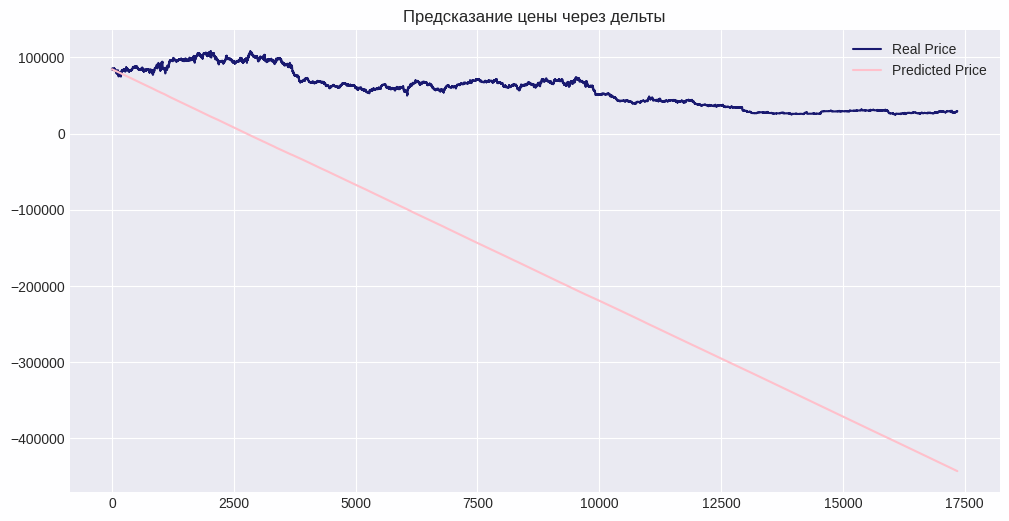

+---------+--------------------+-------------------+
| RESULTS |       TRAIN        |        TEST       |
+---------+--------------------+-------------------+
|   rmse  | 399.5628417926085  | 115.6399815342315 |
|   mae   | 248.72410959077655 | 70.20096532529507 |
|   mape  | 1.9044621176137708 | 3.997426699799142 |
+---------+--------------------+-------------------+


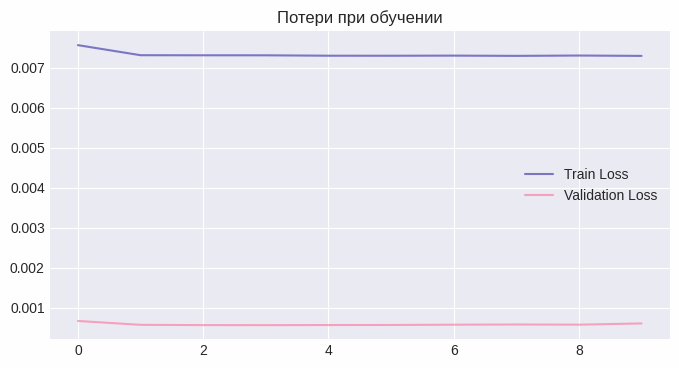

<Sequential name=sequential_28, built=True>

In [ ]:
step= '1h'
unit = 16
companies = 'BTC-USD'
lookback=30
delta_LSTM(step, unit, companies, lookback)